In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')
import random
from random import randint
import math

In [83]:
food_amount = 500
pacman_amount = 200
board_size = 1000
default_health = 1500
pacmen = []
food = []
crot = 1
cloc = .005
cbite = 1
turn_loss = 100
phi_prec = (80/255.)
alpha_prec = 10/255.
delta_prec = 10/255.
pacman_radius = 1
food_health = 300
mutation_freq = .11 # percent any 0/1 would flip for each gene

In [84]:
class pacman:
    def __init__(self):
        #change dynamically
        self.x = random.uniform(49*board_size/100,51*board_size/100)
        self.y = random.uniform(49*board_size/100,51*board_size/100)
        #this is set so the prgression will be outward
        self.theta = randint(0,359)
        self.health = default_health
        self.active = 1
        #dna
        self.phi = randint(0,255)
        self.alpha = randint(0,255)
        self.delta = randint(0,255)
        
        self.phi_val = self.phi*phi_prec
        self.alpha_val = self.alpha*alpha_prec
        self.delta_val = self.delta*delta_prec
        #self.f = closest food
        #self.dist = closest food distance
    def __bool__(self):
        return True
    
    def __repr__(self):
        return "{pacman, x:"+str(self.x)+", y:"+str(self.y)+", theta:"+str(self.theta)+"}"
    
    def find_dist(self,f):
        return np.sqrt((self.x-f.x)**2 + (self.y-f.y)**2)
    
    def find_angle(self,f):
        dx = f.x - self.x
        dy = f.y - self.y
        arc = math.degrees(math.atan((dy/dx)))
        theta1 = 1
        if dx > 0:
            theta1 = 180 - arc
            #this used to be an if, but i think arctan returns a negative when a negative is inputted.
            #therefor the two would be equivalent
        else:
            if dy > 0:
                theta1 = np.absolute(arc)
                #this is absolute because the angle will be a negative
            else:
                theta1 = 360 - arc
        #theta1 is the angle the food is from the x axis
        #returned is the difference in the angles
        return np.absolute(theta1 - self.theta)
    
    def check_angle(self,f):#check if the food is in the range
        diff = (self.phi_val/2)#this creates virutal bounds
        f_angle = self.find_angle(f)
        if(f_angle < diff):
            return True
        return False
        
    def find_food(self):
        global food
        closest = False
        closest_dist = False
        for i in food:
            dist = self.find_dist(i)
            if((dist < closest_dist or not closest_dist) and (self.check_angle(i))):
                closest = i
                closest_dist = dist
            self.f = closest
            self.dist = closest_dist
        if(closest != False):
            return True
        return False
        
    def rotate_to_food(self):# returns (in radians!!!) the angle needed to get the food with genetic error
        #no cost to rotation
        dx =  self.f.x - self.x
        dy =  self.f.y - self.y
        arc = math.atan((dy/dx))
        error = random.uniform(self.alpha_val/-2., self.alpha_val/2.)
        new_theta = arc + error
        return new_theta 
        
    def get_food(self):
        theta = self.rotate_to_food() #warning this is in radians...
        #theta is not used... 
        
        error = random.uniform(self.delta_val/-2., self.delta_val/2.)
        new_dist = self.dist + (error*self.dist)
        #the error for distance is relative to the distance, ie the greater the dist the greater the error
        
        dx =  self.f.x - self.x
        dy =  self.f.y - self.y
        distx = new_dist*(dx/self.dist)#equivalent to cos, error is not associted with the angle yet
        disty = new_dist*(dy/self.dist)#equivalent to sin
        self.x += distx
        self.y += disty
        cost = cloc*new_dist
        self.health -= cost
        #cost of rotate
    
    def bite(self):
        to_food = self.find_dist(self.f)
        self.health -= cbite
        if(to_food < pacman_radius):#means the bite was sucessful
            self.health += food_health
            self.f.reset()
        self.check_bounds()
    def check_bounds(self):
        if(self.x > board_size or self.x < 0):
            self.x = self.x % board_size
        #if(self.x < 0):
        # self.x = board_size + self.x
        if(self.y > board_size or self.y < 0):
            self.y = self.y % board_size
            
            
    
    def random_rotate(self):
        self.theta = randint(0,359)
        #self.health += randint(-2,1)
    
    def step(self):
        self.health -= turn_loss
        if(self.find_food()):
            self.get_food()
            self.bite()
        self.random_rotate()
    
    
    def get_genes(self):
        return[self.phi,self.alpha,self.delta]
    
    def set_genes(self,genes):
        self.phi = genes[0]
        self.alpha = genes[1]
        self.delta = genes[2]
        
    def to_bits(self):
        genes = self.get_genes()
        split_genes = []
        for i in genes:
            bin_str = format(i, '#010b')
            bin_str = bin_str[2:]
            split_genes.append([bin_str[:4],bin_str[4:]])
        return split_genes
    def mutate(self, gene):
        #checks each 1/0 and finds a random num and if it below the threshold it mutates
        new_gene = ''
        for i in gene:
            rand = random.uniform(0,1)
            if(rand < mutation_freq):
                #this means the dna is flipping
                num = int(i)
                if(num == 1):
                    num = 0
                else:
                    num = 1
                new_gene += str(num)
            else:
                new_gene += str(i)
                
        return new_gene
        
        
    def reproduce(self,other):
        son1 = pacman()
        son2 = pacman()
        son1_genes = []
        son2_genes = []
        mybits = self.to_bits()
        otherbits = other.to_bits()
        for i,v in enumerate(mybits):
            son1_gene = v[0]+otherbits[i][1]
            son1_gene = self.mutate(son1_gene)
            son2_gene = otherbits[i][0]+v[1]
            son2_gene = self.mutate(son2_gene)
            son1_gene = int('0b'+son1_gene,base=2)
            son2_gene = int('0b'+son2_gene,base=2)
            son1_genes.append(son1_gene)
            son2_genes.append(son2_gene)
        son1.set_genes(son1_genes)
        son2.set_genes(son2_genes)
        return [son1,son2]
        
        
p = pacman()
p2 = pacman()
print(p.reproduce(p2))

[{pacman, x:498.22747468276367, y:499.5206755462454, theta:215}, {pacman, x:504.93822227013356, y:500.21855789939207, theta:128}]


In [85]:
class dot:
    def __init__(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)
        self.active = 1
    def __repr__(self):
        return "{dot, x:"+str(self.x)+", y:"+str(self.y)+"}"
    def reset(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)

In [86]:
def gen1():
    global pacmen
    pacmen = []
    for i in range(0,pacman_amount):
        p = pacman()
        pacmen.append(p)
    pacmen = np.array(pacmen)
    print(pacmen[0])
    return pacmen

def food1():
    global food
    food = []
    for i in range(0,food_amount):
        f = dot()
        food.append(f)
    food = np.array(food)
    return food

def reproduce1(healthy_pacmen):# takes an array of pacmen and reproduces each with a neibor
    #inactive for now
    sons = []
    for i,v in enumerate(healthy_pacmen):
        if( i % 2 == 1):
            temp = v.reproduce(healthy_pacmen[randint(0,len(healthy_pacmen)-1)])
            sons.extend(temp)
    return sons

def find_average_health(p,x=10): #takes an array of pacmen and finds the averge health
    #it will also sort the pacemen by health and return the helath of the xth pacman
    pacmen_ranked = []
    avg_health = 0
    for i in p:
        pacmen_ranked.append(i.health)
        avg_health += i.health
        
    avg_health = avg_health/len(p)
    pacmen_ranked = np.array(sorted(pacmen_ranked))
    med_health = pacmen_ranked[x]
    print(avg_health, med_health)
    return avg_health, med_health

def reproduce2(healthy_pacmen, x):# takes an array of pacmen and reproduces randomly with other heathy_pacmen
    # x is how many are cut off in the evolution
    sons = []
    total = int(len(healthy_pacmen)/2) + int(x/2) + 1
    for i in range(0,total):
        rand1 = randint(0,len(healthy_pacmen)-1)
        rand2 = randint(0,len(healthy_pacmen)-1)
        p1 = healthy_pacmen[rand1]
        p2 = healthy_pacmen[rand2]
        temp = p1.reproduce(p2)
        sons.extend(temp)
                        
    return sons

def reproduce3(healthy_pacmen):
    myscale = len(pacmen)/2
    sons = []
    total = int(len(pacmen)/2)
    for i in range(0,total):
        rand1 = np.random.exponential(scale=myscale)
        rand2 = np.random.exponential(scale=myscale)
        
        while rand1 > len(pacmen) - 1:
            rand1 = np.random.exponential(scale=myscale)
        while rand2 > len(pacmen) - 1:
            rand2 = np.random.exponential(scale=myscale)
        rand1 = int(rand1)
        rand2 = int(rand2)
        p1 = healthy_pacmen[rand1]
        p2 = healthy_pacmen[rand2]
        temp = p1.reproduce(p2)
        sons.extend(temp)
    return sons
    
def average_genes(p):#phi alpha delta
    avg1 = 0
    avg2 = 0
    avg3 = 0
    for i in p:
        avg1 += i.phi_val
        avg2 += i.alpha_val
        avg3 += i.delta_val
    avg1 = avg1/len(p)
    avg2 = avg2/len(p)
    avg3 = avg3/len(p)
    return avg1,avg2,avg3

def bubbleSort(unranked):
    for passnum in range(len(unranked)-1,0,-1):
        for i in range(passnum):
            if unranked[i].health>unranked[i+1].health:
                temp = unranked[i]
                unranked[i] = unranked[i+1]
                unranked[i+1] = temp



In [87]:
def driver(gen,life_span,generations):
    food = food1()
    dt = 1
    t = [0]
    tracker = []
    genetics = [[],[],[]]
    cycles = []
    
    global pacmen
    
    for g in range(0,generations): #iterates through each generation
        tracker.append([])
        avg1,avg2,avg3 = average_genes(pacmen)
        genetics[0].append(avg1)
        genetics[1].append(avg2)
        genetics[2].append(avg3)
        for i in pacmen:
            tracker[g].append([])
            
        cycles.append([])
        t.append(t[-1]+dt)
        for q in range(0,life_span): #runs through time with current generation
            for i,v in enumerate(pacmen):
                tracker[g][i].append([v.x,v.y,v.theta])
                v.step()
            cycles[g].append([])# note cycles starts after the first gen
            cycles[g][q].append([])
            cycles[g][q].append([])
            cycles[g][q].append([])
            cycles[g][q].append([])
            for w in pacmen:
                cycles[g][q][0].append(w.x)
                cycles[g][q][1].append(w.y)
            for f in food:
                cycles[g][q][2].append(f.x)
                cycles[g][q][3].append(f.y)
                
        
        
        #makes the next generation
        x = 150 # number of pacmen dieing
        healthy_pacmen = []
        avg,med = find_average_health(pacmen,x)
        
        for i,v in enumerate(pacmen): #end of a generation mean reproduce
                if(v.health > med):
                    healthy_pacmen.append(v)
        #this system kills off the bottom x pacmen
        unranked = pacmen
        bubbleSort(unranked)
        ranked = unranked
        
        sons = reproduce3(ranked)
      
        pacmen = sons
        
    return t,tracker,genetics,cycles

In [88]:
t,tracker,genetics,cycles = driver(gen1(),5,100)#turns then generations

{pacman, x:493.0544783148861, y:495.845172466254, theta:232}
1028.9059765 994.240893594
1024.32579648 994.852322862
1021.03955871 994.545399771
1025.96933063 995.224384027
1020.95417367 994.117967475
1030.09832076 995.403324807
1026.93720474 993.88757879
1016.44151014 993.877563973
1037.60730738 995.224818876
1036.04467271 994.986961337
1035.53813501 995.621305341
1024.88852218 994.054153465
1023.33415488 994.393236974
1019.10137518 994.446640319
1017.50716194 994.096217581
1023.2780975 994.413662317
1022.32133282 995.585088081
1027.82036326 994.00569626
1021.643004 993.630452607
1015.85743551 994.687940608
1030.86113101 994.932940325
1025.86814578 994.185909296
1015.33397936 993.576116859
1039.89879038 994.848462398
1028.59342003 993.720932432
1011.95161193 993.168381971
1038.05091561 995.084781553
1023.30277801 994.026169228
1013.94594834 993.945704291
1037.96408282 994.654256891
1004.72518969 993.714870429
1019.42315059 993.495930906
1024.97177624 993.992542753
1030.67370632 994.499

<IPython.core.display.Javascript object>


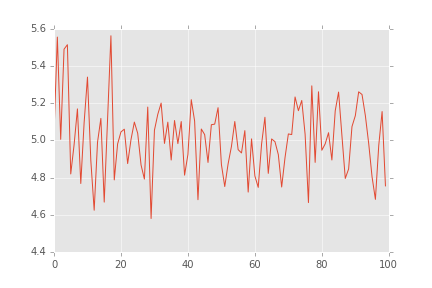

In [90]:
plt.figure()
#plt.plot(genetics[0])# should increase
#plt.plot(genetics[1])#should decrease
plt.plot(genetics[2])#should decrease
# error is disabled

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


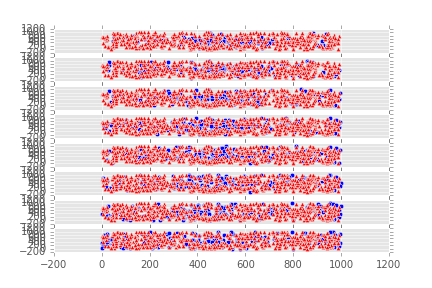

In [76]:
tracker = np.array(tracker)
x = []
for i in tracker[0][0]:
    x.append(i[0])
plt.figure()
plt.plot(x)

figs = 8
gen = 0
f, axarr = plt.subplots(figs, sharex=True,sharey=True)
for i in range(0,figs):
    axarr[i].scatter(cycles[gen][i][0],cycles[gen][i][1])
    axarr[i].scatter(cycles[gen][i][2],cycles[gen][i][3], marker='^',c='red')
    


<IPython.core.display.Javascript object>


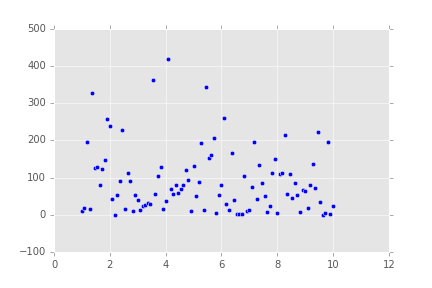

In [55]:
rands = []
for i in range(0,100):
    test = np.random.exponential(scale=100.0)
    rands.append(test)
plt.figure()
plt.scatter(np.linspace(1,10,100),rands)